In [1]:
import numpy as np, basic, cosmology, camb, plottools as pl, local
from matplotlib.pyplot import *
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
cr = rcParams['axes.prop_cycle'].by_key()['color']

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


In [2]:
import importlib
importlib.reload(local)

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


<module 'local' from '/global/u1/t/toshiyan/Work/Ongoing/bispec/z-clean/local.py'>

In [3]:
zmin, zmax = 0.0001, 50.
zn  = 5000
zi  = np.linspace(zmin,zmax,zn)
dz  = zi[1]-zi[0]
Hzi = basic.cosmofuncs.hubble(zi,divc=True,**local.cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**local.cps)

In [4]:
w = {}

In [5]:
w['W1'] = cosmology.window_cib(rzi,zi,local.nu)/Hzi

In [6]:
lmax = 2048
l =  np.arange(0, lmax+1)

In [24]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=local.H0, ombh2=local.ombh2, omch2=local.omch2)
pars.InitPower.set_params(As=local.As, ns=local.ns)
pars.set_for_lmax(lmax, lens_potential_accuracy=5)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
tracers = [ SplinedSourceWindow( z=zi, W=w['W1'], dlog10Ndm=0.4, bias=np.sum(w['W1']*dz) ) ]
pars.SourceWindows = tracers

In [25]:
pars.SourceTerms.counts_redshift = False 
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False

In [26]:
pars.SourceTerms

class: <SourceTermParams>
 limber_windows = True
 limber_phi_lmin = 100
 counts_density = True
 counts_redshift = False
 counts_lensing = False
 counts_velocity = False
 counts_radial = False
 counts_timedelay = False
 counts_ISW = False
 counts_potential = False
 counts_evolve = False
 line_phot_dipole = False
 line_phot_quadrupole = False
 line_basic = True
 line_distortions = True
 line_extra = False
 line_reionization = False
 use_21cm_mK = True
 

In [27]:
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

In [28]:
camb_list = np.concatenate((np.array(['P']),np.array(list(w))))

In [29]:
camb_cls = {}
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if J<I: continue
        if m0 == 'P' and m1 == 'P':
            fac   = 2*np.pi/4.
        elif m0 == 'P' and m1 != 'P':
            fac   = 2*np.pi/np.sqrt((l+1e-30)*(l+1))/2.
        else:
            fac   = 2*np.pi/(l+1e-30)/(l+1)
        camb_cls[m0+m1] = cls[m0+'x'+m1][:lmax+1]*fac

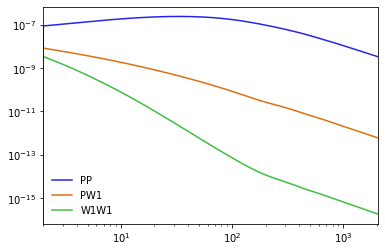

In [30]:
xscale('log')
yscale('log')
xlim(2,lmax)
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if I>J: continue
        plot(l,camb_cls[m0+m1][:lmax+1],label=m0+m1)
legend()

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


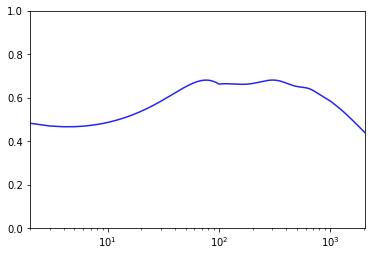

In [31]:
nlII = local.nlII(local.nu,lmax)
rho = camb_cls['PW1'][:lmax+1]/np.sqrt(camb_cls['PP'][:lmax+1]*(camb_cls['W1W1'][:lmax+1]+nlII))
xscale('log')
xlim(2,lmax)
ylim(0,1)
plot(l,rho)

In [14]:
np.savetxt(local.root+'modelw/cl/mass.dat',np.array((l,camb_cls['PP'][:lmax+1],camb_cls['PW1'][:lmax+1],camb_cls['W1W1'][:lmax+1],nlII)).T)